Diego Rosas A01634154

In [204]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import KFold, ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as ln
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, r_regression, SequentialFeatureSelector, RFE
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


#Crime data

In [205]:
df = pd.read_csv('crime_data.csv')

In [206]:
#Debido a que mi matrícula (A01634154) termina en 4, trabajaré con Variable dependiente MR, variables independientes M, W, H y P
columnas_a_eliminar = ['VR', 'S']
df = df.drop(columnas_a_eliminar, axis=1)
df.head()

,State,MR,M,W,H,P
0,AK,9.0,41.8,75.2,86.6,9.1
1,AL,11.6,67.4,73.5,66.9,17.4
2,AR,10.2,44.7,82.9,66.3,20.0
3,AZ,8.6,84.7,88.6,78.7,15.4
4,CA,13.1,96.7,79.3,76.2,18.2


#Gráfica

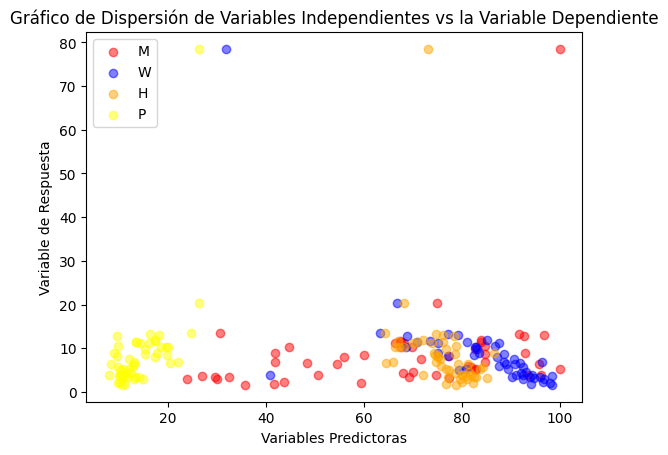

In [207]:
# Grafica cada variable predictora vs la variable de respuesta asignadas a tu número de matrícula (4)
plt.scatter(df['M'], df['MR'], label='M', color='red', alpha=0.5)
plt.scatter(df['W'], df['MR'], label='W', color='blue', alpha=0.5)
plt.scatter(df['H'], df['MR'], label='H', color='orange', alpha=0.5)
plt.scatter(df['P'], df['MR'], label='P', color='yellow', alpha=0.5)

plt.xlabel('Variables Predictoras')
plt.ylabel('Variable de Respuesta')
plt.title('Gráfico de Dispersión de Variables Independientes vs la Variable Dependiente')
plt.legend()
plt.show()

#Modelo regresión

In [208]:
x = df[['M', 'W', 'H', 'P']].values
y = df['MR'].values

# Agregar una columna de unos para el término de intersección
X = np.column_stack((np.ones(x.shape[0]), x))

In [209]:
def fit_model(X, y):
  return np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y
def predict(X, beta):
  return X @ beta

beta = fit_model(X, y)
print ("Model coefficients: ", beta)
y_pred = predict(X, beta)
r = y - y_pred

print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

Model coefficients:  [-39.36237505   0.08937732  -0.41776537   0.72531944   1.5371259 ]
MSE:  35.303326150777515
MAE:  3.7156277068885037
R^2:  0.6865107390948453


In [210]:
# Evaluar modelo con Validación Cruzada
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle = True)
mse_cv = []
mae_cv = []
r2_cv = []
for train_index, test_index in kf.split(x):
  # Fase de entrenamiento
  x_train = x[train_index, :]
  y_train = y[train_index]
  beta_cv = fit_model(x_train, y_train)
  # Fase de prueba
  x_test = x[test_index, :]
  y_test = y[test_index]
  y_pred = predict(x_test, beta_cv)
  # Calcular MSE, MAE y R^2
  mse_i = mean_squared_error(y_test, y_pred)
  print('mse = ', mse_i)
  mse_cv.append(mse_i)
  mae_i = mean_absolute_error(y_test, y_pred)
  print('mae = ', mae_i)
  mae_cv.append(mae_i)
  r2_i = r2_score(y_test, y_pred)
  print('r^2= ', r2_i)
  r2_cv.append(r2_i)
print('MSE:', np.average(mse_cv), ' MAE:', np.average(mae_cv),' R^2:',
np.average(r2_cv))

mse =  6.4573674851107485
mae =  1.796601367125933
r^2=  -0.005121778453226922
mse =  124.24956681559931
mae =  6.548299311817681
r^2=  -2.4544378717696875
mse =  22.085296987376523
mae =  3.9989965932226665
r^2=  -0.9203103224422893
mse =  300.6222111993133
mae =  7.526623032326772
r^2=  0.37880901069664485
mse =  24.523302895694563
mae =  3.632815125219075
r^2=  -1.5835759477132916
MSE: 95.5875490766189  MAE: 4.700667085942426  R^2: -0.9169273819363701


#Monte-Carlo

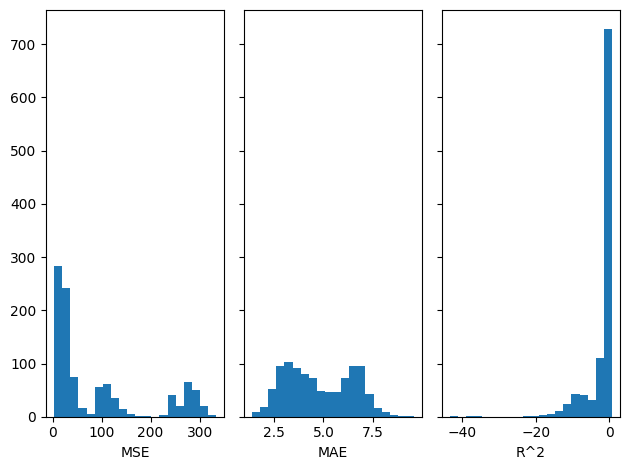

In [211]:
#Debido a que el último número de mi matrícula (A01634154) es par, utilizo Monte-Carlo con al menos 100 particiones
kf = ShuffleSplit(n_splits=1000, test_size = 0.2)
mse_cv = []
mae_cv = []
r2_cv = []
for train_index, test_index in kf.split(x):
  # Training phase
  x_train = x[train_index, :]
  y_train = y[train_index]
  regr_cv = linear_model.LinearRegression()
  regr_cv.fit(x_train, y_train)
  # Test phase
  x_test = x[test_index, :]
  y_test = y[test_index]
  y_pred = regr_cv.predict(x_test)
  # Calculate MSE, MAE and R^2
  mse_i = mean_squared_error(y_test, y_pred)
  mse_cv.append(mse_i)
  mae_i = mean_absolute_error(y_test, y_pred)
  mae_cv.append(mae_i)
  r2_i = r2_score(y_test, y_pred)
  r2_cv.append(r2_i)
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(mse_cv, bins=20)
axs[0].set_xlabel("MSE")
axs[1].hist(mae_cv, bins=20)
axs[1].set_xlabel("MAE")
axs[2].hist(r2_cv, bins=20)
axs[2].set_xlabel("R^2")
plt.show()

#Ridge

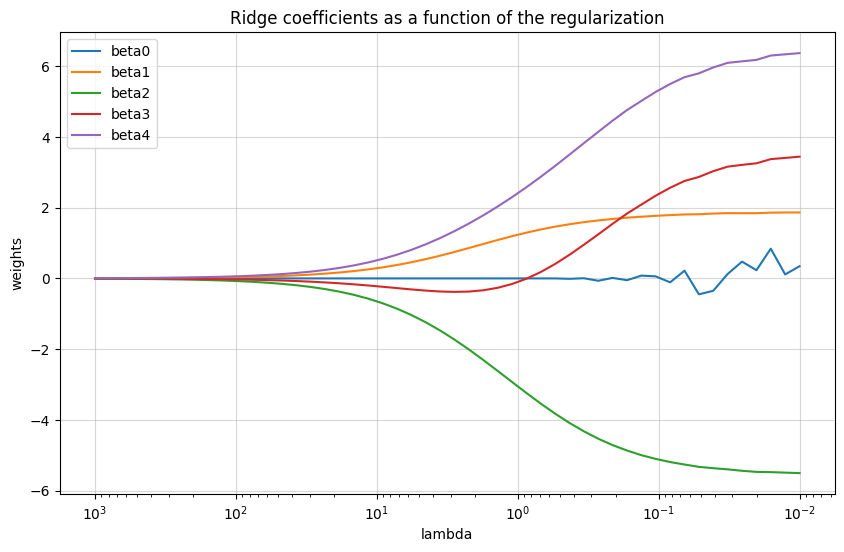

In [212]:
# Error function (it evaluates the mean squared error function for the specified model and data set).
def mse(X, y, beta):
  y_pred = X @ beta
  return (y - y_pred).sum()

# Gradient of error function (it evaluates the gradient of the mean squared error function for the specified model and data set).
def grad(X, y, beta, lambd):
  n = len(y)
  y_pred = X @ beta
  res = y - y_pred
  tmp = res*X.transpose()
  return -(2/n)*tmp.sum(axis = 1) + 2*lambd*beta

def fit_modelRidge(x,y,lambd = 0.1, alpha = 0.0005, maxit = 10000):
  npredictors = x.shape[1]

  beta = 2 * np.random.rand(npredictors)-1.0

  it = 0
  while (np.linalg.norm(grad(x,y,beta,lambd)) > 1e-4) and (it < maxit):
    beta = beta - alpha*grad(x,y,beta,lambd)
    it = it + 1
  return beta

lambdas = np.logspace(-2,3,50)
coefs=[]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

for l in lambdas:
  betaR = fit_modelRidge(X_normalized, y, l)
  coefs.append(betaR)

plt.figure(figsize=(10, 6))
axis = plt.gca()
lineObjects = axis.plot(lambdas, coefs)
axis.set_xscale('log')
axis.set_xlim(axis.get_xlim()[::-1])
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

features = ['beta' + str(feat) for feat in range(coefs[0].shape[0])]
axis.legend(iter(lineObjects), features)

plt.grid(True, alpha=0.5)
plt.show()

#Lasso

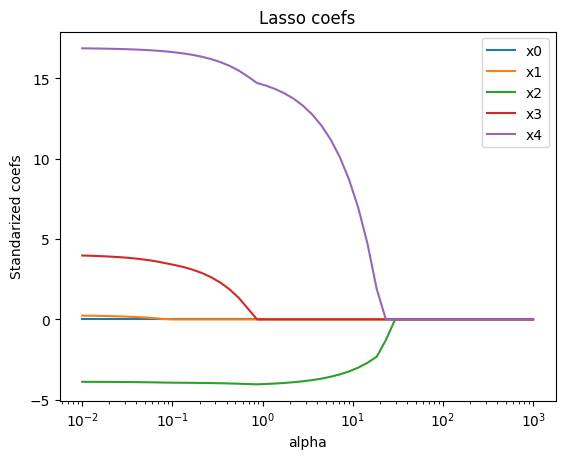

In [213]:
X_train, x_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.8,random_state=42)

alphas = np.logspace(-2, 3, 50)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
  lasso.set_params(alpha=a)
  lasso.fit(X_train, y_train)
  coefs.append(lasso.coef_)

ax = plt.gca()

lineObjects = ax.plot(alphas,coefs)
ax.set_xscale('log')
axis.set_xlim(axis.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standarized coefs')
plt.title('Lasso coefs')
features = ['x' + str(feat) for feat in range(coefs[0].shape[0])]
ax.legend(iter(lineObjects), features)
plt.show()

#Paso 5

In [214]:
df['M2'] = df['M'] ** 2
df['W2'] = df['W'] ** 2
df['H2'] = df['H'] ** 2
df['P2'] = df['P'] ** 2

df['MxW'] = df['M'] * df['W']
df['MxH'] = df['M'] * df['H']
df['MxP'] = df['M'] * df['P']

df['WxH'] = df['W'] * df['H']
df['WxP'] = df['W'] * df['P']

df['HxP'] = df['H'] * df['P']

x = df[['M', 'W', 'H', 'P','M2', 'W2', 'H2', 'P2', 'MxW', 'MxH', 'MxP', 'WxH', 'WxP', 'HxP']].values
y = df['MR'].values

X = np.column_stack((np.ones(x.shape[0]), x))

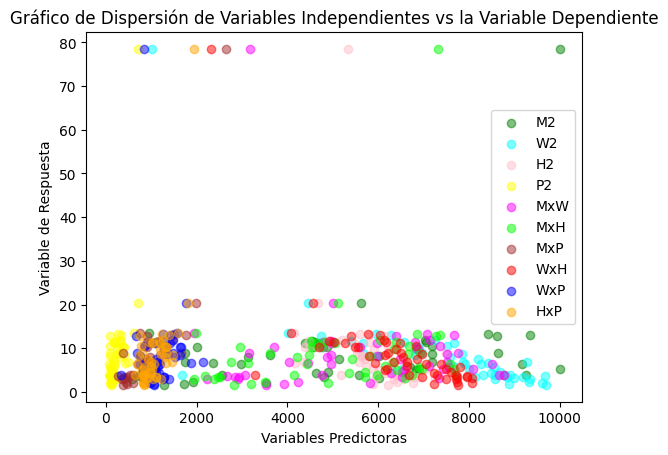

In [215]:
# Grafica cada variable predictora vs la variable de respuesta asignadas a tu número de matrícula
plt.scatter(df['M2'], df['MR'], label='M2', color='green', alpha=0.5)
plt.scatter(df['W2'], df['MR'], label='W2', color='cyan', alpha=0.5)
plt.scatter(df['H2'], df['MR'], label='H2', color='pink', alpha=0.5)
plt.scatter(df['P2'], df['MR'], label='P2', color='yellow', alpha=0.5)
plt.scatter(df['MxW'], df['MR'], label='MxW', color='magenta', alpha=0.5)
plt.scatter(df['MxH'], df['MR'], label='MxH', color='lime', alpha=0.5)
plt.scatter(df['MxP'], df['MR'], label='MxP', color='brown', alpha=0.5)
plt.scatter(df['WxH'], df['MR'], label='WxH', color='red', alpha=0.5)
plt.scatter(df['WxP'], df['MR'], label='WxP', color='blue', alpha=0.5)
plt.scatter(df['HxP'], df['MR'], label='HxP', color='orange', alpha=0.5)

plt.xlabel('Variables Predictoras')
plt.ylabel('Variable de Respuesta')
plt.title('Gráfico de Dispersión de Variables Independientes vs la Variable Dependiente')
plt.legend()
plt.show()

In [216]:
def fit_model(X, y):
  return np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y
def predict(X, beta):
  return X @ beta

beta = fit_model(X, y)
print ("Model coefficients: ", beta)

y_pred = predict(X, beta)
r = y - y_pred

print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

Model coefficients:  [-3.25113064e+02  1.08687952e+00  6.54618874e+00 -8.87160312e-01
  8.45799805e+00 -1.84322460e-03 -3.21933984e-03  3.60095579e-02
 -6.07368534e-02 -9.51354005e-03  1.87395455e-03 -1.02761388e-02
 -5.84703636e-02 -9.25236807e-02  2.91934607e-02]
MSE:  3.3224814328590306
MAE:  1.4051272908453045
R^2:  0.970496767236332


In [217]:
# Evaluar con validación cruzada
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle = True)
mse_cv = []
mae_cv = []
r2_cv = []
for train_index, test_index in kf.split(x):
  # Fase de entrenamiento
  x_train = x[train_index, :]
  y_train = y[train_index]
  beta_cv = fit_model(x_train, y_train)
  # Fase de prueba
  x_test = x[test_index, :]
  y_test = y[test_index]
  y_pred = predict(x_test, beta_cv)
  # Calcular MSE, MAE y R^2
  mse_i = mean_squared_error(y_test, y_pred)
  print('mse = ', mse_i)
  mse_cv.append(mse_i)
  mae_i = mean_absolute_error(y_test, y_pred)
  print('mae = ', mae_i)
  mae_cv.append(mae_i)
  r2_i = r2_score(y_test, y_pred)
  print('r^2= ', r2_i)
  r2_cv.append(r2_i)
print('MSE:', np.average(mse_cv), ' MAE:', np.average(mae_cv),' R^2:',
np.average(r2_cv))

mse =  8.182318580939036
mae =  2.0416422944453023
r^2=  0.4952842302313275
mse =  300.6282501703405
mae =  7.339576181652563
r^2=  0.379972156703518
mse =  13.704842864975882
mae =  2.9599101427095866
r^2=  0.4581374079267486
mse =  9.509951275028547
mae =  2.4572119918217377
r^2=  0.4216941059303385
mse =  24.99970425044566
mae =  3.036595660163804
r^2=  -2.81465213782435
MSE: 71.40501342834591  MAE: 3.5669872541585987  R^2: -0.21191284740648345


#Preguntas

Viendo los resultados de regresión, desarrolla una conclusión sobre los siguientes puntos:

**A. ¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?**

Al ser un modelo no lineal, no podríamos utilizar R2 para responder la pregunta ya que al no tener sentido el resultado no nos sirve, sin embargo podemos basarnos en MAE y MSE, el modelo de regresión lineal nos da este resultado:

MSE:  35.303326150777515
MAE:  3.7156277068885037

Esto nos indica que el modelo no es efectivo, ya que presenta un MSE bastante alto, asimismo, el MAE está un poco más elevado de lo ideal.

**B. ¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada? Detalla tu respuesta.**

Al observar los resultados de validación cruzada, obtenemos los siguiente resultados:

MSE: 102.57668105684017  
MAE: 4.821623688400915

Estos resultados confirman que el modelo no es adecuado, ya que ambos valores de errores (MSE & MAE) subieron con esta validación, principalmente en el MSE se observa una variabilidad importante.

**C. ¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático? ¿Por qué?**

El modelo cuadrático nos otorgó los siguientes resultados:

MSE:  3.3224814328590306
MAE:  1.4051272908453045

Comparándolos con los resultados del modelo lineal podemos observar que la variabilidad es bastante importante, con el modelo cuadrático los errores de redujeron sustancialmente acercándose a 0, por lo tanto, a partir de esto podemos concluir que el modelo cuadrático es mejor.

**D. ¿Qué variables son más relevantes para el modelo según Ride y Lasso?**

Según las gráficas de Ridge y Lasso, las variables más relevantes serían x2, x3, y x4, ya que en ambos gráficos x0 y x1 se encuentran bastante cercanos a cero.

**E. ¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?**

La relación mas interesante que noté es que el haber elevado las variables predictoras al cuadrado y haber multiplicado pares mejoró bastante la variable de respuesta, en este caso MR.

#Life expectancy

In [218]:
# Cargar el conjunto de datos
data = pd.read_csv("life_expectancy_data.csv")
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [219]:
column_list = data.columns.tolist()

print(column_list)

['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [220]:
#Debido a que el antepenúltimo número de mi matrícula (A01634154) es 5, trabajaré con todas las variables, menos X3, X7, X11, X15

x = data[['Adult Mortality', 'infant deaths', 'percentage expenditure', 'Hepatitis B', 'Measles ', 'under-five deaths ', 'Polio', 'Total expenditure', ' HIV/AIDS', 'GDP', 'Population', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']].fillna(0).values
y = data['Life expectancy '].fillna(0).values

#Modelo regresión lineal

In [221]:
# Definir el modelo de regresión lineal
model = LinearRegression()

# Realizar la validación cruzada con 5 folds
scores = cross_val_score(model, x, y, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio promedio de todas las iteraciones
mean_mse = -scores.mean()

print("Error cuadrático medio promedio:", mean_mse)

Error cuadrático medio promedio: 42.4593001572263


#Filter

In [222]:
features = x
n_features = len(features)
fselection = SelectKBest(r_regression, k = 5)
fselection.fit(x, y)
print("Selected features: ", fselection.get_feature_names_out())

Selected features:  ['x2' 'x6' 'x9' 'x12' 'x13']


In [223]:
regr = linear_model.LinearRegression()
x_transformed = fselection.transform(x)
regr.fit(x_transformed, y)
print("Model coefficients: ", regr.coef_)
print("Model intercept: ", regr.intercept_)

y_pred = regr.predict(x_transformed)
print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

Model coefficients:  [2.15573215e-04 1.02858337e-01 1.02576159e-04 1.22763844e+01
 3.58839334e-01]
Model intercept:  48.412676320698544
MSE:  60.885193563213946
MAE:  5.076181866579087
R^2:  0.4289496616689128


MSE: 61.505327702710154  MAE: 5.09626134907438  R^2: 0.4228303947094797
---- n features = 1
MSE: 70.65651690862168  MAE: 5.5825453509098875  R^2: 0.3377902198931221
---- n features = 2
MSE: 69.67146801664401  MAE: 5.443900134299115  R^2: 0.340825588225505
---- n features = 3
MSE: 63.75448431726376  MAE: 5.185366582880654  R^2: 0.4065479280149652
---- n features = 4
MSE: 61.38802607321156  MAE: 5.094144561300507  R^2: 0.4258231907412931
---- n features = 5
MSE: 61.09818074864394  MAE: 5.084744575500114  R^2: 0.4279050790242748
---- n features = 6
MSE: 61.19861708101514  MAE: 5.079280846222438  R^2: 0.4304932328504111
---- n features = 7
MSE: 61.35951547665961  MAE: 5.08384404223918  R^2: 0.42382297683213094
---- n features = 8
MSE: 61.016895801978784  MAE: 5.069525279130421  R^2: 0.42946721810266475
---- n features = 9
MSE: 61.196015212370014  MAE: 5.082915812823026  R^2: 0.4272524744930844
Optimal number of features:  8


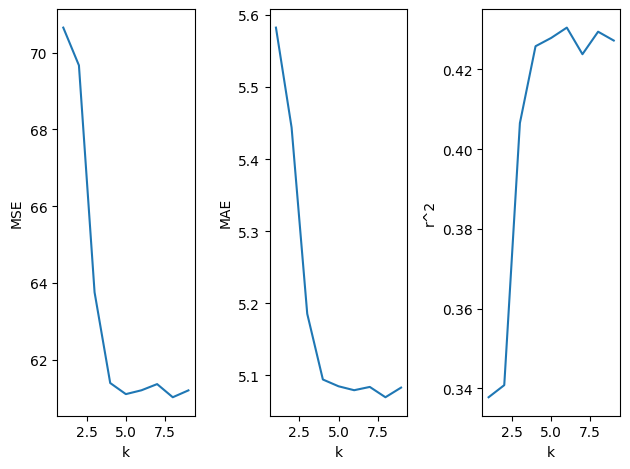

In [224]:
mse_cv = []
mae_cv = []
r2_cv = []
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(x):

  x_train = x[train_index, :]
  y_train = y[train_index]
  fselection_cv = SelectKBest(r_regression, k=5)
  fselection_cv.fit(x_train, y_train)
  x_train = fselection_cv.transform(x_train)
  regr_cv = linear_model.LinearRegression()
  regr_cv.fit(x_train, y_train)

  x_test = fselection_cv.transform(x[test_index, :])
  y_test = y[test_index]
  y_pred = regr_cv.predict(x_test)
  mse_i = mean_squared_error(y_test, y_pred)
  mse_cv.append(mse_i)
  mae_i = mean_absolute_error(y_test, y_pred)
  mae_cv.append(mae_i)
  r2_i = r2_score(y_test, y_pred)
  r2_cv.append(r2_i)
print('MSE:', np.average(mse_cv), ' MAE:', np.average(mae_cv),' R^2:',
np.average(r2_cv))

n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mse_nfeat = []
mae_nfeat = []
r2_nfeat = []
for n_feat in n_feats:
  print('---- n features =', n_feat)
  mse_cv = []
  mae_cv = []
  r2_cv = []
  kf = KFold(n_splits=5, shuffle = True)
  for train_index, test_index in kf.split(x):

    x_train = x[train_index, :]
    y_train = y[train_index]
    fselection_cv = SelectKBest(r_regression, k = n_feat)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)
    regr_cv = linear_model.LinearRegression()
    regr_cv.fit(x_train, y_train)

    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = regr_cv.predict(x_test)
    mse_i = mean_squared_error(y_test, y_pred)
    mse_cv.append(mse_i)
    mae_i = mean_absolute_error(y_test, y_pred)
    mae_cv.append(mae_i)
    r2_i = r2_score(y_test, y_pred)
    r2_cv.append(r2_i)
  mse = np.average(mse_cv)
  mse_nfeat.append(mse)
  mae = np.average(mae_cv)
  mae_nfeat.append(mae)
  r2 = np.average(r2_cv)
  r2_nfeat.append(r2)
  print('MSE:', mse, ' MAE:', mae,' R^2:', r2)

opt_index = np.argmin(mse_nfeat)
opt_features = n_feats[opt_index]
print("Optimal number of features: ", opt_features)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("k")
axs[0].set_ylabel("MSE")
axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("k")
axs[1].set_ylabel("MAE")
axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("k")
axs[2].set_ylabel("r^2")
plt.show()

#Wrapper

In [225]:
regr = linear_model.LinearRegression()
fselection = SequentialFeatureSelector(regr, n_features_to_select = 0.5)
fselection.fit(x, y)
print("Selected features: ", fselection.get_feature_names_out())

x_transformed = fselection.transform(x)
regr.fit(x_transformed, y)
print("Model coefficients: ", regr.coef_)
print("Model intercept: ", regr.intercept_)
y_pred = regr.predict(x_transformed)
print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

Selected features:  ['x0' 'x6' 'x8' 'x9' 'x11' 'x12' 'x13']
Model coefficients:  [-2.00688146e-02  7.02384758e-02 -5.24413075e-01  8.49536052e-05
 -2.70279041e-01  7.61218565e+00  3.26474201e-01]
Model intercept:  59.99691513989962
MSE:  40.25514969950212
MAE:  3.719613347395593
R^2:  0.6224415903087785


MSE: 41.06347339032823   MAE: 3.757632355772312   R^2: 0.6202382216499975
----- Optimal selection of number of features -----
---- n features = 1
MSE: 67.09634023346248   MAE: 5.179989483369633   R^2: 0.37420554225221064
---- n features = 2
MSE: 52.16987165287564   MAE: 4.248369143591722   R^2: 0.5122738672646328
---- n features = 3
MSE: 47.344854032261445   MAE: 4.132447352123615   R^2: 0.5629683784835274
---- n features = 4
MSE: 43.79586458613536   MAE: 4.004871844635906   R^2: 0.5942600300327948
---- n features = 5
MSE: 42.08849162746877   MAE: 3.843772944566138   R^2: 0.6074726403875078
---- n features = 6
MSE: 41.282673471508005   MAE: 3.80118319483189   R^2: 0.6206549038641518
---- n features = 7
MSE: 41.118950270862385   MAE: 3.772376943734043   R^2: 0.6205905929831952
---- n features = 8
MSE: 40.88087254699777   MAE: 3.745635694265739   R^2: 0.6198109283162065
---- n features = 9
MSE: 41.12740142640839   MAE: 3.7475280142570115   R^2: 0.6234579400594099
Optimal number of featur

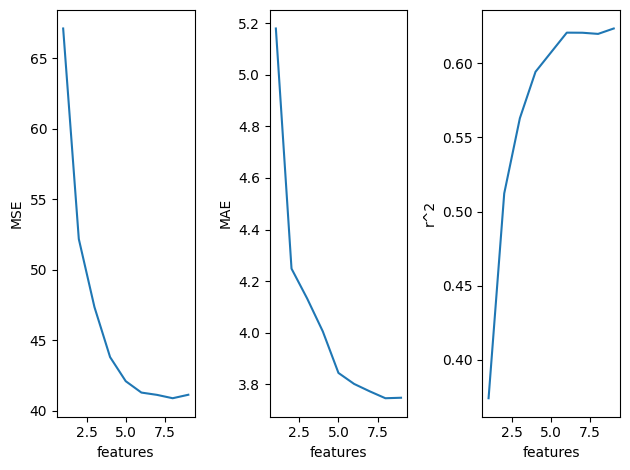

Selected features:  ['x0' 'x2' 'x6' 'x8' 'x9' 'x11' 'x12' 'x13']
Model coefficients:  [-2.00808150e-02  1.91391118e-04  7.05875446e-02 -5.24749004e-01
  5.91455389e-05 -2.68466627e-01  7.68478315e+00  3.23659791e-01]
Model intercept:  59.973410428133135


In [226]:
# Evaluate model using cross validation
mse_cv = []
mae_cv = []
r2_cv = []

kf = KFold(n_splits=5, shuffle = True)

for train_index, test_index in kf.split(x):

    # Training phase
    x_train = x[train_index, :]
    y_train = y[train_index]

    regr_cv = linear_model.LinearRegression()

    fselection_cv = SequentialFeatureSelector(regr_cv, n_features_to_select=0.5)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)

    regr_cv.fit(x_train, y_train)

    # Test phase
    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = regr_cv.predict(x_test)

    mse_i = mean_squared_error(y_test, y_pred)
    mse_cv.append(mse_i)

    mae_i = mean_absolute_error(y_test, y_pred)
    mae_cv.append(mae_i)

    r2_i = r2_score(y_test, y_pred)
    r2_cv.append(r2_i)


print('MSE:', np.average(mse_cv), '  MAE:', np.average(mae_cv),'  R^2:', np.average(r2_cv))

n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9]

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []
for n_feat in n_feats:
    print('---- n features =', n_feat)

    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle = True)

    for train_index, test_index in kf.split(x):

        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]

        regr_cv = linear_model.LinearRegression()

        fselection_cv = SequentialFeatureSelector(regr_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv.fit(x_train, y_train)

        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

opt_index = np.argmin(mse_nfeat)
opt_features = n_feats[opt_index]
print("Optimal number of features: ", opt_features)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("features")
axs[0].set_ylabel("MSE")

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("features")
axs[1].set_ylabel("MAE")

axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("features")
axs[2].set_ylabel("r^2")

plt.show()

# Fit model with optimal number of features
regr = linear_model.LinearRegression()
fselection = SequentialFeatureSelector(regr, n_features_to_select = opt_features)
fselection.fit(x, y)

print("Selected features: ", fselection.get_feature_names_out())

x_transformed = fselection.transform(x)
regr.fit(x_transformed, y)
print("Model coefficients: ", regr.coef_)
print("Model intercept: ", regr.intercept_)

#Filter-Wrapper

In [227]:
regr = linear_model.LinearRegression()
fselection = RFE(regr, n_features_to_select = 0.5)
fselection.fit(x, y)
print("Selected features: ", fselection.get_feature_names_out())

x_transformed = fselection.transform(x)
regr.fit(x_transformed, y)
print("Model coefficients: ", regr.coef_)
print("Model intercept: ", regr.intercept_)
y_pred = regr.predict(x_transformed)
print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

Selected features:  ['x1' 'x5' 'x7' 'x8' 'x11' 'x12' 'x13']
Model coefficients:  [ 0.15703133 -0.11669927  0.21857926 -0.74770443 -0.38121258 10.50719024
  0.47668496]
Model intercept:  59.45716513576616
MSE:  46.34235756429093
MAE:  4.290742913837814
R^2:  0.5653488571294014


MSE: 46.68767994274291   MAE: 4.301111280353847   R^2: 0.5627815101070122
---- n features = 1
MSE: 70.8722506682775   MAE: 5.5879264655116625   R^2: 0.33281207802439705
---- n features = 2
MSE: 53.744290159844034   MAE: 4.748388932630924   R^2: 0.49368721716161057
---- n features = 3
MSE: 52.15952520520805   MAE: 4.577623264652109   R^2: 0.5105539595652783
---- n features = 4
MSE: 49.466790837877625   MAE: 4.447106186150803   R^2: 0.5385557982086733
---- n features = 5
MSE: 49.15973919330201   MAE: 4.42365632326146   R^2: 0.539536257023081
---- n features = 6
MSE: 49.01284136430128   MAE: 4.416742042525945   R^2: 0.5428883719500813
---- n features = 7
MSE: 46.849773300942786   MAE: 4.307320395573373   R^2: 0.5635130790226653
---- n features = 8
MSE: 44.58578241322215   MAE: 4.165767312639993   R^2: 0.5840752821659742
---- n features = 9
MSE: 40.46144214907959   MAE: 3.717571630908773   R^2: 0.6345768893220939
Optimal number of features:  9


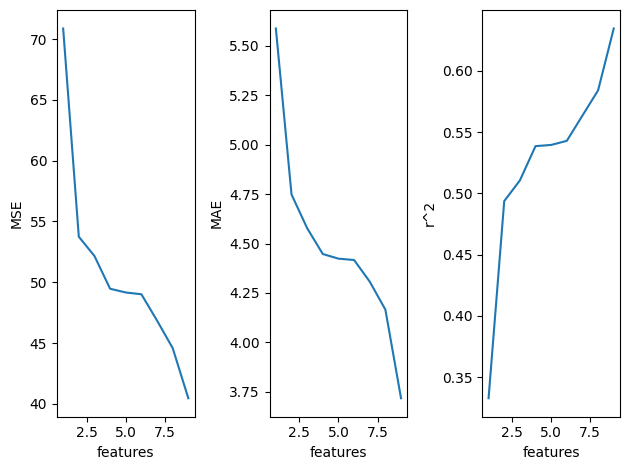

Selected features:  ['x0' 'x1' 'x5' 'x6' 'x7' 'x8' 'x11' 'x12' 'x13']
Model coefficients:  [-0.0202829   0.11599441 -0.08618894  0.06173905  0.11423589 -0.50600956
 -0.29787643  8.30788007  0.34862484]
Model intercept:  60.187819182232985


In [228]:
# Evaluar con validación cruzada
mse_cv = []
mae_cv = []
r2_cv = []

kf = KFold(n_splits=5, shuffle = True)

for train_index, test_index in kf.split(x):

    x_train = x[train_index, :]
    y_train = y[train_index]

    regr_cv = linear_model.LinearRegression()

    fselection_cv = RFE(regr_cv, n_features_to_select=0.5)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)

    regr_cv.fit(x_train, y_train)

    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = regr_cv.predict(x_test)

    mse_i = mean_squared_error(y_test, y_pred)
    mse_cv.append(mse_i)

    mae_i = mean_absolute_error(y_test, y_pred)
    mae_cv.append(mae_i)

    r2_i = r2_score(y_test, y_pred)
    r2_cv.append(r2_i)

print('MSE:', np.average(mse_cv), '  MAE:', np.average(mae_cv),'  R^2:', np.average(r2_cv))


n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9]

mse_nfeat = []
mae_nfeat = []
r2_nfeat = []
for n_feat in n_feats:
    print('---- n features =', n_feat)

    mse_cv = []
    mae_cv = []
    r2_cv = []

    kf = KFold(n_splits=5, shuffle = True)

    for train_index, test_index in kf.split(x):

        x_train = x[train_index, :]
        y_train = y[train_index]

        regr_cv = linear_model.LinearRegression()

        fselection_cv = RFE(regr_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)

        regr_cv.fit(x_train, y_train)

        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = regr_cv.predict(x_test)

        mse_i = mean_squared_error(y_test, y_pred)
        mse_cv.append(mse_i)

        mae_i = mean_absolute_error(y_test, y_pred)
        mae_cv.append(mae_i)

        r2_i = r2_score(y_test, y_pred)
        r2_cv.append(r2_i)


    mse = np.average(mse_cv)
    mse_nfeat.append(mse)

    mae = np.average(mae_cv)
    mae_nfeat.append(mae)

    r2 = np.average(r2_cv)
    r2_nfeat.append(r2)

    print('MSE:', mse, '  MAE:', mae,'  R^2:', r2)

opt_index = np.argmin(mse_nfeat)
opt_features = n_feats[opt_index]
print("Optimal number of features: ", opt_features)

fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].plot(n_feats, mse_nfeat)
axs[0].set_xlabel("features")
axs[0].set_ylabel("MSE")

axs[1].plot(n_feats, mae_nfeat)
axs[1].set_xlabel("features")
axs[1].set_ylabel("MAE")

axs[2].plot(n_feats, r2_nfeat)
axs[2].set_xlabel("features")
axs[2].set_ylabel("r^2")

plt.show()

regr = linear_model.LinearRegression()
fselection = RFE(regr, n_features_to_select = opt_features)
fselection.fit(x, y)

print("Selected features: ", fselection.get_feature_names_out())

x_transformed = fselection.transform(x)
regr.fit(x_transformed, y)
print("Model coefficients: ", regr.coef_)
print("Model intercept: ", regr.intercept_)


#K-vecinos

In [229]:
model_knn = KNeighborsRegressor()
model_knn.fit(x, y)
y_pred_knn = model_knn.predict(x)

mse_knn = mean_squared_error(y, y_pred_knn)
mae_knn = mean_absolute_error(y, y_pred_knn)
r2_knn = r2_score(y, y_pred_knn)

print("Mean Squared Error (MSE):", mse_knn)
print("Mean Absolute Error (MAE):", mae_knn)
print("R-squared (R2):", r2_knn)

Mean Squared Error (MSE): 57.97311749489449
Mean Absolute Error (MAE): 5.356065350578625
R-squared (R2): 0.4562624109062646


#Arbol de decisión

In [230]:
# Agregar "Status" como variable predictora
df_status = data[['Adult Mortality', 'Status','infant deaths', 'percentage expenditure',
                'Hepatitis B', 'Measles ', 'under-five deaths ', 'Polio', 'Total expenditure',
                ' HIV/AIDS', 'GDP', 'Population', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']]

df_status.head()

,Adult Mortality,Status,infant deaths,percentage expenditure,Hepatitis B,Measles,under-five deaths,Polio,Total expenditure,HIV/AIDS,GDP,Population,thinness 5-9 years,Income composition of resources,Schooling
0,263.0,Developing,62,71.279624,65.0,1154,83,6.0,8.16,0.1,584.259210,33736494.0,17.3,0.479,10.1
1,271.0,Developing,64,73.523582,62.0,492,86,58.0,8.18,0.1,612.696514,327582.0,17.5,0.476,10.0
2,268.0,Developing,66,73.219243,64.0,430,89,62.0,8.13,0.1,631.744976,31731688.0,17.7,0.470,9.9
3,272.0,Developing,69,78.184215,67.0,2787,93,67.0,8.52,0.1,669.959000,3696958.0,18.0,0.463,9.8
4,275.0,Developing,71,7.097109,68.0,3013,97,68.0,7.87,0.1,63.537231,2978599.0,18.2,0.454,9.5


In [231]:
df_status = pd.get_dummies(data, columns = ['Status'], prefix = 'status')
status = df_status.to_numpy()

In [232]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(x, y)

DecisionTreeRegressor()

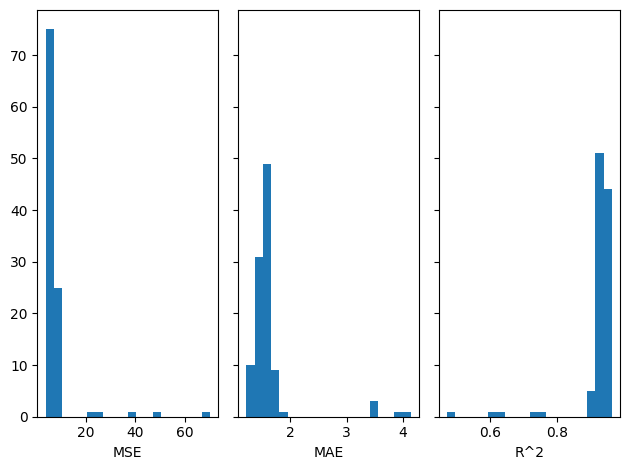

MSE: 8.264457400685034  MAE: 1.6299394330235148  R^2: 0.9210662231527791


In [233]:
# Monte - Carlo
monte_carlo = ShuffleSplit(n_splits=100)
r2_d = []
mse_d = []
mae_d = []

for train_index, test_index in monte_carlo.split(status):

  x_train = x[train_index, :]
  y_train = y[train_index]

  decision_tree.fit(x_train, y_train)

  x_test = x[test_index, :]
  y_test = y[test_index]

  y_pred2 = decision_tree.predict(x_test)

  mse_i = mean_squared_error(y_test, y_pred2)
  mse_cv.append(mse_i)
  mae_i = mean_absolute_error(y_test, y_pred2)
  mae_cv.append(mae_i)
  r2_i = r2_score(y_test, y_pred2)
  r2_cv.append(r2_i)

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(mse_cv, bins=20)
axs[0].set_xlabel("MSE")

axs[1].hist(mae_cv, bins=20)
axs[1].set_xlabel("MAE")

axs[2].hist(r2_cv, bins=20)
axs[2].set_xlabel("R^2")

plt.show()
print('MSE:', np.average(mse_cv), ' MAE:', np.average(mae_cv),' R^2:', np.average(r2_cv))

#Preguntas

**Consideras que el modelo de regresión lineal es adecuado para los datos. ¿Por qué?**

En el modelo de regresión lineal se obtuvo un MSE de 42.4593001572263, lo cual quiere decir que el modelo no es adecuado para los datos, el error es bastante alto.

**¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?**

A partir de los diferentes métodos se obtuvieron los siguientes resultados:

Filter:
MSE:  60.885193563213946
MAE:  5.076181866579087
R^2:  0.4289496616689128

Wrapper:
MSE:  40.25514969950212
MAE:  3.719613347395593
R^2:  0.6224415903087785

Filter-Wrapper:
MSE:  46.34235756429093
MAE:  4.290742913837814
R^2:  0.5653488571294014

Analizando los resultados, el mejor sería el método de wrapper, ya que tiene los MSE y MAE más bajos que los demás, asimismo, wrapper tiene la R2 mas alta, lo cual nos indica mayor exactitud.

**Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes? ¿Qué información relevantes observas de dichas características?**

Analizando las características seleccionadas por los modelos, las mas destacables son X12 - HIV/AIDS & X13 - GDP, las cuales aparecen en los 3 modelos.

**¿El modelo de regresión no lineal funcionó mejor que el lineal? ¿Por qué?**

Los resultados del modelo no lineal fueron los siguientes:

Mean Squared Error (MSE): 57.97311749489449
Mean Absolute Error (MAE): 5.356065350578625
R-squared (R2): 0.4562624109062646

Estos datos nos indican que no es mejor que el lineal, ya que el MSE del no lineal: 57.97311749489449 es más alto que el del lineal 4593001572263.

**¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"? ¿Por qué?**

Analizando los datos obtenidos del arbol de decisión:

MSE: 8.11080714223865  
MAE: 1.619109969114834  
R^2: 0.9219332901964165

Podemos concluir que si mejoró el modelo sustancialmente, ya que los errores se redujeron bastante y la r2 se acerca a 1 lo cual indica una buena cercanía del modelo a la realidad.

**¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión? Argumenta tu respuesta.**

Considero que lo más interesante de los resultados de modelar con regresión es como el hacer una regresión lineal o no lineal puede cambiar el desempeño del modelo, es importante experimentar con diversos modelos y analizar las métricas de MSE, R2 y MAE para obtener el mejor modelo posible. Asimismo, algo interesente es que agregar variables predictoras, como 'Status' en este caso, puede mejorar sustancialmente un modelo, es importante evaluar cada variable y experimentar para saber si una variable puede mejorar el modelo o lo emepeora.